In [1]:
import pandas as pd
import numpy as np
import joblib

import h3
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import lightgbm as lgb

import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

c:\Users\leois\Documents\Projetos\Nasa Space Apps\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Generate train dataset

In [65]:
df_sharks = pd.read_csv("../downloads/sharks/period/sharks_h3r5_2015-01-01_2025-01-01.csv")
df_sharks['raw_date'] = df_sharks['date']
df_sharks['date'] = pd.to_datetime(df_sharks['date'], format='mixed', errors='coerce', dayfirst=False, utc=True)
df_sharks['year'] = df_sharks['date'].dt.year.astype('Int64').astype(str)
df_sharks['data'] = df_sharks['date'].dt.to_period('M').astype(str) + '-01'

C:\Users\leois\AppData\Local\Temp\ipykernel_30068\3517773504.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_sharks['data'] = df_sharks['date'].dt.to_period('M').astype(str) + '-01'


In [ ]:
chrolo_files = os.listdir("../downloads/planctons/csv/")
chrolo_vars = ['chlor_a_mean', 'chlor_a_min', 'chlor_a_max', 'chlor_a_std']
chrolo_vars.extend(['h3', 'data'])
sst_files = os.listdir("../downloads/sst/csv/")
sst_vars = ['sst_mean', 'sst_min', 'sst_max', 'sst_std']
sst_vars.extend(['h3', 'data'])
r1 = pd.DataFrame()
control_h3_1 = pd.DataFrame()
for f in chrolo_files:
    tmp = pd.read_csv(f"../downloads/planctons/csv/{f}")[chrolo_vars]
    tmp1 = pd.merge(df_sharks, tmp, on=['h3', 'data'])
    control_h3_1 = pd.concat([control_h3_1, tmp[~tmp['h3'].isin(tmp1['h3'].values)][chrolo_vars].sample(max([len(tmp1), 1]), replace=True)])
    r1 = pd.concat([r1, tmp1])


r = pd.DataFrame()
control_h3 = pd.DataFrame()
for f in sst_files:
    tmp = pd.read_csv(f"../downloads/sst/csv/{f}")[sst_vars]
    tmp1 = pd.merge(r1, tmp, on=['h3', 'data'])
    control_h3_tmp = pd.merge(control_h3_1, tmp, on=['h3', 'data'])
    control_h3 = pd.concat([control_h3, control_h3_tmp])
    r = pd.concat([r, tmp1])

In [69]:
full_control = pd.DataFrame()
for s in r.species.unique():
    tmp_c = control_h3.copy()
    tmp_c['species'] = s
    tmp_c['n_obs'] = 0
    full_control = pd.concat([full_control, tmp_c])

In [70]:
full_df = pd.concat([full_control, r[full_control.columns]])

In [71]:
pd.get_dummies(full_df[['chlor_a_mean', 'chlor_a_min', 'chlor_a_max', 'chlor_a_std', 'sst_mean', 'sst_min', 'sst_max', 'sst_std', 'species',
       'n_obs']], dtype=int).to_csv("downloads/model_data.csv", index=False)

# Generate dataset for predict

In [ ]:
chrolo_files = os.listdir("../downloads/planctons/csv/")
chrolo_vars = ['chlor_a_mean', 'chlor_a_min', 'chlor_a_max', 'chlor_a_std', 'centroid_lat', 'centroid_lon']
chrolo_vars.extend(['h3', 'data'])
sst_files = os.listdir("../downloads/sst/csv/")
sst_vars = ['sst_mean', 'sst_min', 'sst_max', 'sst_std']
sst_vars.extend(['h3', 'data'])
r1 = pd.DataFrame()
control_h3_1 = pd.DataFrame()
f = chrolo_files[-1]
tmp_current1 = pd.read_csv(f"../downloads/planctons/csv/{f}")[chrolo_vars]

f = sst_files[-1]
tmp_current2 = pd.read_csv(f"../downloads/sst/csv/{f}")[sst_vars]
tmp_current_full = pd.merge(tmp_current1, tmp_current2, on=['h3', 'data'])

In [93]:
tmp_current_full.to_csv("downloads/current_env_data.csv", index=False)

# Train model

In [4]:
# Load and prepare the data
df = pd.read_csv('downloads/model_data.csv')
df = df[['chlor_a_mean', 'chlor_a_min', 'chlor_a_max', 'chlor_a_std', 'sst_mean',
       'sst_min', 'sst_max', 'sst_std', 'species_Carcharhinus',
       'species_Carcharodon', 'species_Galeocerdo', 'species_Prionace',
       'species_Sphyrna', 'n_obs']]
df['n_obs'] = (df['n_obs'] > 0).astype(int)
# Assuming the last column is the target variable
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create LightGBM datasets
train_data = lgb.Dataset(X_train_scaled, label=y_train)
test_data = lgb.Dataset(X_test_scaled, label=y_test, reference=train_data)

In [5]:
# Set model parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'num_boost_round': 100,
    'verbose': 20
}

# Train the model
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'valid']
)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

c:\Users\leois\Documents\Projetos\Nasa Space Apps\.venv\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.800000
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.307692
[LightGBM] [Debug] init for col-wise cost 0.001424 seconds, init for row-wise cost 0.002123 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2055
[LightGBM] [Info] Number of data points in the train set: 18320, number of used features: 13
[LightGBM] [Info] Start training from score 0.167467
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[Ligh

<Figure size 1000x600 with 0 Axes>

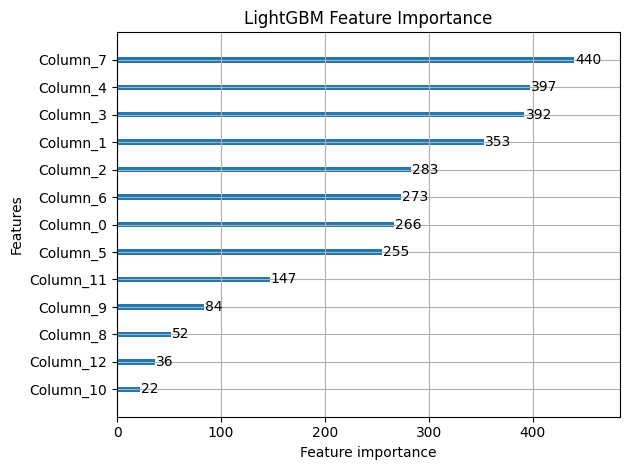

C:\Users\leois\AppData\Local\Temp\ipykernel_21372\2512555860.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, show=False)


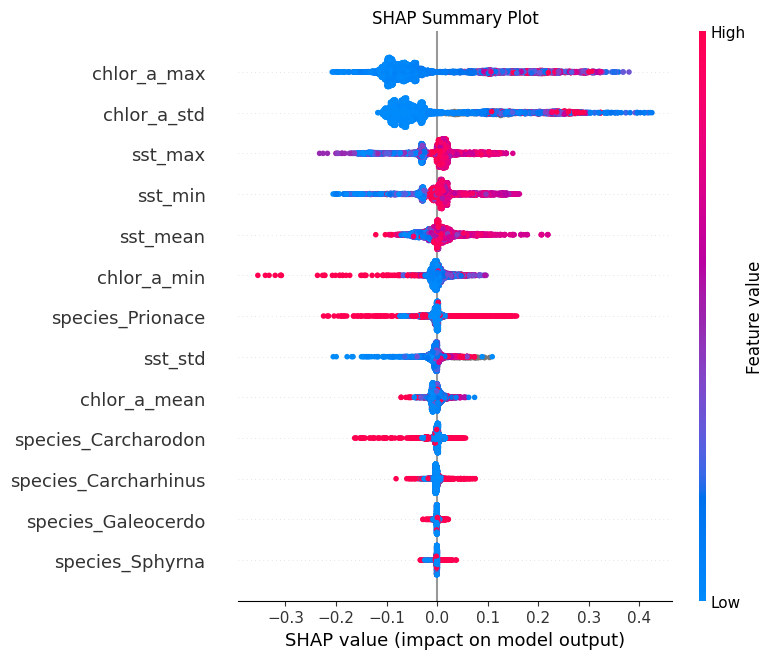

In [6]:
# Plot feature importance
plt.figure(figsize=(10, 6))
lgb.plot_importance(model, max_num_features=20)
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

# Calculate and plot SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)

# Summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, show=False)
plt.title('SHAP Summary Plot')
plt.tight_layout()
plt.show()

In [7]:
# Save the model and the scaler
# Create a directory for models if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the LightGBM model
model_path = 'models/lightgbm_regression_model.txt'
model.save_model(model_path)
print(f"Model saved to: {model_path}")

# Save the scaler
scaler_path = 'models/scaler.joblib'
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

# Example of how to load the model and scaler for future use
print("\nExample of loading the saved model and scaler:")
print("loaded_model = lgb.Booster(model_file='models/lightgbm_regression_model.txt')")
print("loaded_scaler = joblib.load('models/scaler.joblib')")

Model saved to: models/lightgbm_regression_model.txt
Scaler saved to: models/scaler.joblib

Example of loading the saved model and scaler:
loaded_model = lgb.Booster(model_file='models/lightgbm_regression_model.txt')
loaded_scaler = joblib.load('models/scaler.joblib')


# Predict on full global data

In [ ]:
sample_predict = pd.read_csv('downloads/current_env_data.csv')
for specie in ['Carcharhinus', 'Carcharodon', 'Galeocerdo', 'Prionace', 'Sphyrna']:
    df_sample = sample_predict.copy()
    df_sample[['species_Carcharhinus', 'species_Carcharodon', 'species_Galeocerdo', 'species_Prionace', 'species_Sphyrna']] = 0
    df_sample[f'species_{specie}'] = 1
    
    df_test = scaler.transform(df_sample[['chlor_a_mean', 'chlor_a_min', 'chlor_a_max', 'chlor_a_std', 
                                   'sst_mean',
                                   'sst_min', 'sst_max', 'sst_std', 
                                   'species_Carcharhinus',
                                   'species_Carcharodon', 'species_Galeocerdo', 'species_Prionace',
                                   'species_Sphyrna']])
    df_final = df_sample[['centroid_lat', 'centroid_lon', 'h3']]
    df_final['prediction'] = model.predict(df_test)
    df_final.loc[df_final['prediction'] < 0, 'prediction'] = 0
    df_final['prediction'] = round(df_final['prediction'], 2)
    df_final.to_csv(f'downloads/predictions_full_{specie}.csv', index=False)

C:\Users\leois\AppData\Local\Temp\ipykernel_21372\1756004538.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['prediction'] = model.predict(df_test)
C:\Users\leois\AppData\Local\Temp\ipykernel_21372\1756004538.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['prediction'] = round(df_final['prediction'], 2)
C:\Users\leois\AppData\Local\Temp\ipykernel_21372\1756004538.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

# Downscaling data

## Chlorophyll

In [ ]:
df = pd.read_csv("../downloads/planctons/csv/AQUA_MODIS.20250101_20250131.L3m.MO.CHL.chlor_a.9km.h3r5.csv")
df['h3'] = df['h3'].apply(lambda x: h3.cell_to_parent(x))
df = df.groupby(['data', 'h3']).agg(
    chlor_a_mean=	('chlor_a_mean', 'mean'),
    chlor_a_min=	('chlor_a_min', 'mean'),
    chlor_a_max=	('chlor_a_max', 'mean'),
    chlor_a_std=	('chlor_a_std', 'mean')
).reset_index().fillna(0)
df['centroid_lat'] = df['h3'].apply(lambda x: h3.cell_to_latlng(x)[0])
df['centroid_lng'] = df['h3'].apply(lambda x: h3.cell_to_latlng(x)[1])
df.to_csv('web/public/data/h3r4/AQUA_MODIS.20250101_20250131.L3m.MO.CHL.chlor_a.9km.h3r5.csv', index=False)

## SST (Sea Surface Temperature)

In [11]:
df = pd.read_csv("../downloads/sst/csv/AQUA_MODIS.20250101_20250131.L3m.MO.SST.sst.9km.h3r5.csv")
df['h3'] = df['h3'].apply(lambda x: h3.cell_to_parent(x))
df = df.groupby(['data', 'h3']).agg(
    sst_mean=	('sst_mean', 'mean'),
    sst_min=	('sst_min', 'mean'),
    sst_max=	('sst_max', 'mean'),
    sst_std=	('sst_std', 'mean')
).reset_index().fillna(0)
df['centroid_lat'] = df['h3'].apply(lambda x: h3.cell_to_latlng(x)[0])
df['centroid_lng'] = df['h3'].apply(lambda x: h3.cell_to_latlng(x)[1])
df.to_csv('web/public/data/h3r4/AQUA_MODIS.20250101_20250131.L3m.MO.SST.sst.9km.h3r5.csv', index=False)

## Predicts

In [ ]:

for specie in ['Carcharhinus', 'Carcharodon', 'Galeocerdo', 'Prionace', 'Sphyrna']:
    df1 = pd.read_csv(f"web/public/data/predictions_full_{specie}.csv")
    df1['h3'] = df1['h3'].apply(lambda x: h3.cell_to_parent(x))
    df1 = df1.groupby(['h3']).agg(
        prediction=	('prediction', 'max')
    ).reset_index().fillna(0)
    df1['centroid_lat'] = df1['h3'].apply(lambda x: h3.cell_to_latlng(x)[0])
    df1['centroid_lng'] = df1['h3'].apply(lambda x: h3.cell_to_latlng(x)[1])
    df1.to_csv(f'web/public/data/h3r4/predictions_full_{specie}.csv', index=False)

## Shark Ocurrences

In [ ]:
df = pd.read_csv("web/public/data/backup/sharks_h3r5_2015-01-01_2025-01-01.csv")
df['h3'] = df['h3'].apply(lambda x: h3.cell_to_parent(x))
df = df.groupby(['date', 'species', 'h3']).agg(
    n_obs=('n_obs', 'sum')
).reset_index().fillna(0)
df['centroid_lat'] = df['h3'].apply(lambda x: h3.cell_to_latlng(x)[0])
df['centroid_lng'] = df['h3'].apply(lambda x: h3.cell_to_latlng(x)[1])
df.to_csv('web/public/data/h3r4/sharks_h3r5_2015-01-01_2025-01-01.csv', index=False)